# 학습 관련 기술들


## 매개변수 갱신

신경망 학습의 목적은 손실함수의 값을 가능한 낮추는 매개변수를 찾는 것
* 손실함수의 값을 낮추는 매개변수를 찾는것? 최적 매개변수를 찾는 문제와 동치.
  * 이러한 문제를 푸는 것을 최적화라고 한다.

    

In [12]:
# 최적화 방법

# coding: utf-8
import numpy as np

class SGD:

    """確率的勾配降下法（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


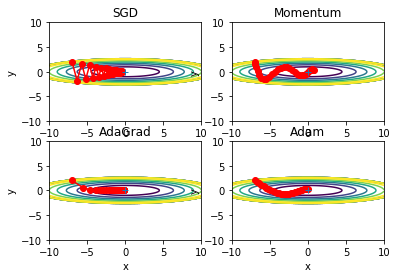

In [10]:
# 최적화 방법 비교

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

===========iteration:0===========
AdaGrad:2.00510609842
Adam:2.14667512851
Momentum:2.35633157058
SGD:2.32231697669
===========iteration:100===========
AdaGrad:0.116299833909
Adam:0.193805743643
Momentum:0.256706015638
SGD:1.48962880312
===========iteration:200===========
AdaGrad:0.0731623058966
Adam:0.163530935157
Momentum:0.218344659016
SGD:0.798409407892
===========iteration:300===========
AdaGrad:0.089083678118
Adam:0.139577675257
Momentum:0.214362743195
SGD:0.670231462868
===========iteration:400===========
AdaGrad:0.0640984555243
Adam:0.139009219009
Momentum:0.154718839105
SGD:0.405684692166
===========iteration:500===========
AdaGrad:0.0589148609475
Adam:0.113974151407
Momentum:0.237279721212
SGD:0.409012801923
===========iteration:600===========
AdaGrad:0.0911506394459
Adam:0.170399837779
Momentum:0.187123320519
SGD:0.375270351517
===========iteration:700===========
AdaGrad:0.0995686586589
Adam:0.135393089493
Momentum:0.212702533182
SGD:0.470856986625
===========iteration:800==

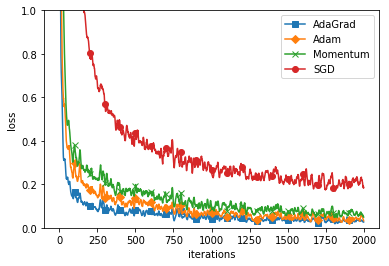

In [11]:
# 최적화 방법 비교 MNIST

# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


In [13]:
# 배치 정규화

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100], output_size=10,
                              use_batchnorm=True)

x_batch = x_train[:1]
t_batch = t_train[:1]

grad_backprop = network.gradient(x_batch, t_batch)
grad_numerical = network.numerical_gradient(x_batch, t_batch)


for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

b2:0.0
W3:0.0
b1:0.0
W1:0.0
gamma2:0.0
beta2:0.0551881568714
beta1:0.0
b3:1.20126128489e-10
W2:0.0
gamma1:0.0


============== 1/16 ==============


/home/malkoring/academic/data-science/deep-learning-from-scratch/common/functions.py:56: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


epoch:0 | 0.099 - 0.082
epoch:1 | 0.117 - 0.102
epoch:2 | 0.117 - 0.148
epoch:3 | 0.116 - 0.184
epoch:4 | 0.116 - 0.214
epoch:5 | 0.117 - 0.228
epoch:6 | 0.117 - 0.25
epoch:7 | 0.116 - 0.269
epoch:8 | 0.116 - 0.303
epoch:9 | 0.116 - 0.32
epoch:10 | 0.116 - 0.351
epoch:11 | 0.116 - 0.351
epoch:12 | 0.116 - 0.384
epoch:13 | 0.116 - 0.401
epoch:14 | 0.116 - 0.418
epoch:15 | 0.116 - 0.42
epoch:16 | 0.116 - 0.426
epoch:17 | 0.116 - 0.431
epoch:18 | 0.116 - 0.448
epoch:19 | 0.116 - 0.465


/home/malkoring/.pyenv/bin/versions/3.5.0/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


============== 2/16 ==============
epoch:0 | 0.117 - 0.146


/home/malkoring/academic/data-science/deep-learning-from-scratch/common/layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)
/home/malkoring/academic/data-science/deep-learning-from-scratch/common/multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/home/malkoring/academic/data-science/deep-learning-from-scratch/common/multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.133
epoch:2 | 0.097 - 0.138
epoch:3 | 0.097 - 0.163
epoch:4 | 0.097 - 0.174
epoch:5 | 0.097 - 0.19
epoch:6 | 0.097 - 0.199
epoch:7 | 0.097 - 0.231
epoch:8 | 0.097 - 0.258
epoch:9 | 0.097 - 0.278
epoch:10 | 0.097 - 0.291
epoch:11 | 0.097 - 0.313
epoch:12 | 0.097 - 0.338
epoch:13 | 0.097 - 0.361
epoch:14 | 0.097 - 0.375
epoch:15 | 0.097 - 0.397
epoch:16 | 0.097 - 0.415
epoch:17 | 0.097 - 0.429
epoch:18 | 0.097 - 0.441
epoch:19 | 0.097 - 0.458
============== 3/16 ==============
epoch:0 | 0.117 - 0.093
epoch:1 | 0.319 - 0.132
epoch:2 | 0.455 - 0.16
epoch:3 | 0.542 - 0.214
epoch:4 | 0.621 - 0.269
epoch:5 | 0.693 - 0.305
epoch:6 | 0.725 - 0.328
epoch:7 | 0.782 - 0.355
epoch:8 | 0.827 - 0.387
epoch:9 | 0.86 - 0.405
epoch:10 | 0.883 - 0.432
epoch:11 | 0.903 - 0.453
epoch:12 | 0.917 - 0.472
epoch:13 | 0.936 - 0.505
epoch:14 | 0.95 - 0.529
epoch:15 | 0.959 - 0.541
epoch:16 | 0.964 - 0.563
epoch:17 | 0.972 - 0.584
epoch:18 | 0.976 - 0.604
epoch:19 | 0.98 - 0.629
==============

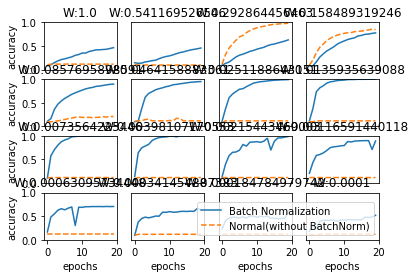

In [14]:
# coding: utf-8

# 배치 정규화 테스트
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

## 올바르게 학습시키기

* 기계학습에서 오버피팅이 문제가 되는 경우가 많다.
  * 오버피팅이란 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태를 의미함.
  * 기계학습은 범용 성능을 지향하기 때문에, 훈련 데이터에는 포함되지 않는 Feature에도 바르게 식별해내는 모델이 바람직하다.

### 오버피팅

* 오버피팅은 두 가지 경우에 일어난다
  * 매개변수가 많고 표현력이 높은 모델
  * 훈련 데이터가 적음

### 가중치 감소

* 오버피팅 억제용으로 많이 사용된다.
  * 큰 가중치에 대해서 그에 상응하는 큰 패널티를 부과하여 오버피팅을 억제한다.
    * 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문
* 손실함수에 가중치의 L2 법칙을 더한다.
    
### 드롭아웃
* 가중치 감소는 간단하게 구현할 수 있고, 어느 정도 지나친 학습을 억제할 수 있으나, 신경망 모델이 복잡해지면 가중치 감소만으로는 대응하기 어려워진다.
* 드롭아웃은 뉴런을 임의로 삭제하면서 학습하는 방법이다.
  * 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제하고, 삭제된 뉴런은 신호를 전달하지 않게 된다. 
  * 훈련때는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택하고, 시험때는 모든 뉴런에 신호를 전달한다.
    * 시험 때는 각 뉴런의 출력에 훈련 때 삭제한 비율을 곱하여 출력
    
 

epoch:0, train acc:0.0766666666667, test acc:0.0947
epoch:1, train acc:0.0766666666667, test acc:0.0964
epoch:2, train acc:0.103333333333, test acc:0.1057
epoch:3, train acc:0.13, test acc:0.1211
epoch:4, train acc:0.166666666667, test acc:0.1411
epoch:5, train acc:0.176666666667, test acc:0.1497
epoch:6, train acc:0.21, test acc:0.169
epoch:7, train acc:0.23, test acc:0.1866
epoch:8, train acc:0.256666666667, test acc:0.2036
epoch:9, train acc:0.266666666667, test acc:0.2091
epoch:10, train acc:0.29, test acc:0.2289
epoch:11, train acc:0.306666666667, test acc:0.2377
epoch:12, train acc:0.313333333333, test acc:0.2507
epoch:13, train acc:0.34, test acc:0.2585
epoch:14, train acc:0.346666666667, test acc:0.2697
epoch:15, train acc:0.363333333333, test acc:0.2856
epoch:16, train acc:0.38, test acc:0.2955
epoch:17, train acc:0.393333333333, test acc:0.3027
epoch:18, train acc:0.41, test acc:0.3073
epoch:19, train acc:0.416666666667, test acc:0.3122
epoch:20, train acc:0.443333333333, tes

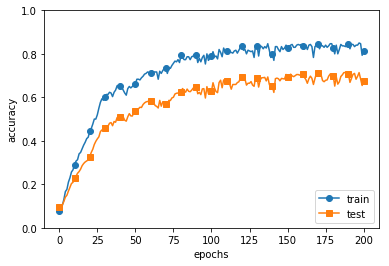

In [7]:
# coding: utf-8

# 가중치 감소
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

train loss:2.3214826566
=== epoch:1, train acc:0.116666666667, test acc:0.098 ===
train loss:2.31017278124
train loss:2.31366067641
train loss:2.29826561983
=== epoch:2, train acc:0.116666666667, test acc:0.1032 ===
train loss:2.30837009085
train loss:2.30494939658
train loss:2.29866829362
=== epoch:3, train acc:0.113333333333, test acc:0.1053 ===
train loss:2.30963272905
train loss:2.28896547678
train loss:2.31107080938
=== epoch:4, train acc:0.12, test acc:0.1103 ===
train loss:2.31052050975
train loss:2.32203635633
train loss:2.29158039361
=== epoch:5, train acc:0.126666666667, test acc:0.1114 ===
train loss:2.29293256312
train loss:2.29763634536
train loss:2.29417769627
=== epoch:6, train acc:0.126666666667, test acc:0.1129 ===
train loss:2.30447549249
train loss:2.30438545526
train loss:2.30725125546
=== epoch:7, train acc:0.133333333333, test acc:0.1157 ===
train loss:2.28582544913
train loss:2.28661593907
train loss:2.31043589795
=== epoch:8, train acc:0.14, test acc:0.1175 ===


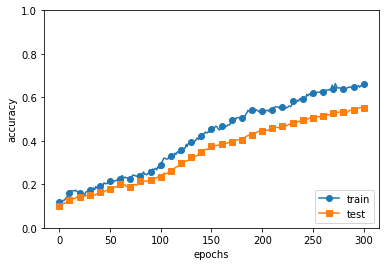

In [4]:
# coding: utf-8

# 드롭아웃
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 적절한 하이퍼파라미터 값 찾기

* 신경망에는 하이퍼파라미터가 다수 등장한다.
  * 하이퍼파라미터는 각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시 학습률과 가중치 감소 같은 것들을 포함한다.
  * 이러한 하이퍼 파라미터의 값을 적절히 설정하지 않으면 모델의 성능이 크게 떨어지기도 한다.
  
### 검증 데이터

* 훈련데이터로 학습하고, 시험데이터로 범용 성능을 평가한다.
  * 시험데이터를 통해, 훈련데이터에만 오버피팅한 건 아닌지, 범용 성능이 어느 정도인지 평가할 수 있다.
* 하이퍼파라미터의 성능을 평가할 때 시험데이터를 사용해서 안 된다.
  * 시험 데이터를 사용하여 하이퍼파라미터를 조정하면 하이퍼파라미터 값이 시험데이터에 오버피팅되기 때문이다.
* 검증데이터란? 하이퍼파라미터의 적절성을 평가하는 하이퍼파라미터 조정용 데이터.
  * MNIST 데이터셋에서 검증데이터를 얻는 가장 간단한 방법은 훈련 데이터 중 20% 정도를 검중데이터로 먼저 분리

### 하이퍼파라미터 최적화 구현

In [2]:

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = x_train.shape[0] * validation_rate
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


TypeError: slice indices must be integers or None or have an __index__ method